### Bayesian Personalized Ranking from Implicit Feedback
https://arxiv.org/ftp/arxiv/papers/1205/1205.2618.pdf

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Flatten, Input, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score

In [4]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Analyse Dataset

### Amazon product review   Dataset
- https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews?resource=download

In [5]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!gdown https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb

Downloading...
From: https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb
To: /content/ratings_Electronics.csv
100% 319M/319M [00:00<00:00, 323MB/s]


#### Consider movies rated by more than 30 users

In [7]:
rating_df =pd.read_csv('ratings_Electronics.csv',  names=['userId','item','rating','time'])
rating_df=rating_df[['userId','item','rating','time']]

x = rating_df.groupby('userId').count()['rating'] >= 30
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['userId'].isin(userIndex)]
y = nm_rating_df.groupby('item').count()['rating']>=30
items = y[y].index
rating_df = nm_rating_df[nm_rating_df['item'].isin(items)]
rating_df.shape

(51702, 4)

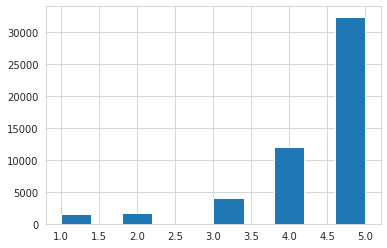

In [8]:
rating_df['rating'].hist()

In [9]:
unique_users = rating_df.userId.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.item.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [10]:
rating_df['userId'] = rating_df.userId.apply(lambda u: user_ids[u])
rating_df['item'] = rating_df.item.apply(lambda m: item_ids[m])

### Prepare train test set

In [11]:
final_ratings=rating_df.sort_values(by=['userId','time'], ascending=[False,False]) 
final_ratings.shape

(51702, 4)

In [12]:
test_df=final_ratings.groupby('userId').head(10)
test_df.shape

(37368, 4)

In [13]:
final_ratings=final_ratings[~final_ratings.isin(test_df).all(1)]
final_ratings.shape

(14334, 4)

In [14]:
test_df.head(1)

,userId,item,rating,time
7627092,5175,879,2.0,1391472000


In [15]:
train_df=final_ratings

In [16]:
df_triplest = pd.DataFrame(columns=['userId', 'positive_id', 'negative_id'])

data = []
users_without_data = []

for user_id in train_df.userId.unique():
    positive_items = train_df[(train_df.userId == user_id) & (train_df.rating > 3)].item.values
    negative_items = train_df[(train_df.userId == user_id) & (train_df.rating <= 3)].item.values

    if negative_items.shape[0] == 0 or positive_items.shape[0] == 0:
        users_without_data.append(user_id)
        continue

    for pos_itm in positive_items:
        for neg_itm in negative_items:
            data.append({'userId': user_id, 'positive_id': pos_itm, 'negative_id': neg_itm})

df_triplest = df_triplest.append(data, ignore_index=True)

In [17]:
df_triplest.head(5)

,userId,positive_id,negative_id
0,5104,680,576
1,5090,705,540
2,5090,664,540
3,5090,669,540
4,5078,838,902


In [18]:
# The assumption is that the recommendations should as many as possible high ranked movies 
# that a specific user has already watched.

ground_truth_train = train_df[train_df.rating > 3].groupby('userId').item.agg(list).reset_index()

ground_truth_train.head(1)

,userId,item
0,1,"[0, 358, 603, 548, 342, 276, 3, 350, 227, 299,..."


In [50]:
ground_truth_test = test_df.groupby('userId').item.agg(list).reset_index()


In [51]:
ground_truth_test.head(4)

,userId,item
0,0,"[8, 27, 57, 1, 0]"
1,1,"[751, 809, 686, 768, 648, 754, 736, 620, 613, ..."
2,2,"[811, 840, 533, 567, 317, 0]"
3,3,"[569, 672, 307, 157, 231, 656, 461, 0]"


### Build model

In [19]:
num_users = unique_users.shape[0]
num_items = unique_items.shape[0]

num_users, num_items

(5176, 919)

In [21]:
unique_item_ids = list(rating_df.item.unique())

In [22]:
def predict(model: Model, user_id: int, item_ids: list, user_layer='user_embedding', item_layer='item_embedding'):
    """
    Prediction  by multiplying user vector by item matrix
    
    """
    user_vector = model.get_layer(user_layer).get_weights()[0][user_id]
    item_matrix = model.get_layer(item_layer).get_weights()[0][item_ids]

    scores = (np.dot(user_vector, item_matrix.T))

    return scores

In [23]:
@tf.function
def identity_loss(_, y_pred):
    return tf.math.reduce_mean(y_pred)

In [26]:
@tf.function
def bpr_loss(X: dict):
    """
    Calculate triplet loss - as higher the difference between positive interactions
    and negative interactions as better
    """
    positive_item_latent, negative_item_latent, user_latent = X

    positive_interactions = tf.math.reduce_sum(tf.math.multiply(user_latent, positive_item_latent), axis=-1, keepdims=True)
    negative_interactions = tf.math.reduce_sum(tf.math.multiply(user_latent, negative_item_latent), axis=-1, keepdims=True)

    return tf.math.subtract(tf.constant(1.0), tf.sigmoid(tf.math.subtract(positive_interactions, negative_interactions)))

In [27]:
def out_shape(shapes):
    return shapes[0]
    

def build_model(num_users: int, num_items: int, latent_dim: int) -> Model:
    """
    Build a model for Bayesian personalized ranking

    :param num_users: a number of the unique users
    :param num_items: a number of the unique movies
    :param latent_dim: vector length for the latent representation
    :return: Model
    """
    user_input = Input((1,), name='user_input')

    positive_item_input = Input((1,), name='positive_item_input')
    negative_item_input = Input((1,), name='negative_item_input')
    # One embedding layer is shared between positive and negative items
    item_embedding_layer = Embedding(num_items, latent_dim, name='item_embedding', input_length=1)

    positive_item_embedding = Flatten()(item_embedding_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_embedding_layer(negative_item_input))

    user_embedding = Embedding(num_users, latent_dim, name='user_embedding', input_length=1)(user_input)
    user_embedding = Flatten()(user_embedding)

    triplet_loss = Lambda(bpr_loss, output_shape=out_shape)([positive_item_embedding,
                                                             negative_item_embedding,
                                                             user_embedding])

    model = Model(inputs=[positive_item_input, negative_item_input, user_input], outputs=triplet_loss)

    return model

In [38]:
latent_dim = 256
batch_size = 256
num_epochs = 10
lr = 0.001

model = build_model(num_users, num_items, latent_dim)
model.compile(loss=identity_loss, optimizer=Adam(learning_rate=lr))

In [39]:
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total number of parameters: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable number of parameters: {:,}'.format(trainable_count))
print('Non-trainable number of parameters: {:,}'.format(non_trainable_count))

print('Training data length: {:,}'.format(df_triplest.shape[0]))

Total number of parameters: 1,560,320.0
Trainable number of parameters: 1,560,320
Non-trainable number of parameters: 0.0
Training data length: 28,121


In [40]:


X = {
    'user_input': tf.convert_to_tensor(np.asarray(df_triplest.userId).astype(np.float32)),
    'positive_item_input': tf.convert_to_tensor(np.asarray(df_triplest.positive_id).astype(np.float32)),
    'negative_item_input': tf.convert_to_tensor(np.asarray(df_triplest.negative_id).astype(np.float32))
}

model.fit(X, 
          tf.ones(df_triplest.shape[0]), 
          batch_size=batch_size,
          epochs=num_epochs)

# model.save(path.join(DIR_MODEL, 'model.h5'))

Epoch 1/10
110/110 [==============================] - 1s 5ms/step - loss: 0.4415
Epoch 2/10
110/110 [==============================] - 1s 6ms/step - loss: 0.2118
Epoch 3/10
110/110 [==============================] - 1s 5ms/step - loss: 0.0723
Epoch 4/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0301
Epoch 5/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 6/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 8/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 9/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 10/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0024


In [42]:
from collections import OrderedDict
from typing import Dict

In [43]:
def full_auc(model: Model, ground_truth: Dict[int, list], items: list) -> float:
    """
    Measure AUC for model and ground truth for all items
    
    """

    number_of_items = len(items)
    scores = []

    for user_id, true_item_ids in ground_truth:
        predictions = predict(model, user_id, items)
        grnd = np.zeros(number_of_items, dtype=np.int32)

        for p in true_item_ids:
            index = items.index(p)
            grnd[index] = 1

        if true_item_ids:
            scores.append(roc_auc_score(grnd, predictions))

    return sum(scores) / len(scores)

In [45]:
def mean_average_precision_k(model: Model, 
                           ground_truth: Dict[int, list], 
                           items: list, 
                           k=100) -> float:
    """
    Calculate mean eavarage precission per user
    
    """
    scores = []

    for user, actual in ground_truth:
        predictions = predict(model, user, items)
        predictions = dict(zip(items, predictions))
        predictions = sorted(predictions.items(), key=lambda kv: kv[1], reverse=True)[:k]
        predictions = list(OrderedDict(predictions).keys())

        score = 0.0
        num_hits = 0.0

        for i, p in enumerate(predictions):
            if p in actual:
                num_hits += 1.0
                score += num_hits / (i + 1.0)

        score = score / min(len(actual), k)
        scores.append(score)

    return np.mean(scores)

In [54]:
def hitrate(model: Model, 
                           ground_truth: Dict[int, list], 
                           items: list, 
                           k=100) -> float:
    """
    Calculate mean eavarage precission per user
    
    """
    total=0
    hit=0

    for user, actual in ground_truth:
        predictions = predict(model, user, items)
        predictions = dict(zip(items, predictions))
        predictions = sorted(predictions.items(), key=lambda kv: kv[1], reverse=True)[:k]
        predictions = list(OrderedDict(predictions).keys())

        total+=1

        for i, p in enumerate(predictions):
            if p in actual:
                   hit += 1
                   break

        

    return  hit/total

### Train

In [46]:
print(f'AUC train: {full_auc(model, ground_truth_train.values, unique_item_ids)}')

AUC train: 0.7228738943982751


In [48]:
print(f'Mean average precision train: {mean_average_precision_k(model, ground_truth_train.values, unique_item_ids)}')

Mean average precision train: 0.25452058919320025


In [56]:
print(f'Hit rate train: {hitrate(model, ground_truth_train.values, unique_item_ids)}')

Hit rate train: 0.6914584543869843


### Test

In [52]:
print(f'AUC test: {full_auc(model, ground_truth_test.values, unique_item_ids)}')

AUC test: 0.5002489259508822


In [53]:
print(f'Mean average precision test: {mean_average_precision_k(model, ground_truth_test.values, unique_item_ids)}')

Mean average precision test: 0.006488302349610706


In [55]:
print(f'Hit rate test: {hitrate(model, ground_truth_test.values, unique_item_ids)}')

Hit rate test: 0.5585394126738794
